In [1]:
# Imports & Warnings
import os
import json
import librosa
import pandas as pd
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
# Mantiene el path inicial al home dir del repositorio
os.chdir(os.path.abspath(".."))

In [3]:
# Carga del archivo directorio con datos necesarios
df_annotations = pd.read_excel("data/annotations.xlsx")

In [4]:
PC_Num, Part_Num = 1536, 1

### Target Data

In [5]:
# Lectura de diccionario de tragets
with open('data/targets_mean_vote_dict.json') as file:
    target_dict = json.load(file)

In [6]:
# Diccionario de inicio y fin de la conversación por id
target_dict['MSP-Conversation_0021.wav']['tupla_start_end']

{'0': [0.04, 2.92],
 '1': [3.32, 5.08],
 '2': [5.12, 5.6],
 '3': [6.2, 8.2],
 '4': [8.2, 10.66],
 '5': [10.86, 12.16],
 '6': [13.62, 15.82],
 '7': [16.66, 19.82],
 '8': [19.86, 20.1],
 '9': [20.76, 23.88],
 '10': [24.74, 25.08],
 '11': [25.62, 25.84],
 '12': [25.98, 28.32],
 '13': [28.66, 30.84],
 '14': [31.0, 31.4],
 '15': [31.48, 33.3],
 '16': [33.7, 33.9],
 '17': [33.9, 34.16],
 '18': [34.52, 37.42],
 '19': [37.48, 38.76],
 '20': [39.02, 40.84],
 '21': [41.4, 41.5],
 '22': [41.56, 43.3],
 '23': [43.44, 44.12],
 '24': [44.54, 44.66],
 '25': [44.98, 45.9],
 '26': [46.22, 47.1],
 '27': [47.86, 49.22],
 '28': [51.96, 54.12],
 '29': [54.32, 54.6],
 '30': [54.62, 54.94],
 '31': [54.94, 57.6],
 '32': [57.7, 58.52],
 '33': [58.76, 63.2],
 '34': [64.02, 66.44],
 '35': [66.64, 66.86],
 '36': [67.58, 70.94],
 '37': [71.94, 72.06],
 '38': [73.7, 77.02],
 '39': [77.08, 82.9],
 '40': [83.4, 83.58],
 '41': [83.62, 88.62],
 '42': [89.08, 89.5],
 '43': [91.52, 92.32],
 '44': [92.62, 92.86],
 '45': [

In [7]:
# Diccionario de votos promedio por id
target_dict['MSP-Conversation_0021.wav']['mean_vote_target']

{'0': [17.006580337490828, 17.010861544911435, 13.172100408762184],
 '1': [25.54989863547758, 28.508631578947373, 22.27673015873016],
 '2': [24.514366812227074, 28.761515907673118, 24.087604491578293],
 '3': [30.354905595605906, 30.132199499779315, 25.261118140356036],
 '4': [34.14229554427524, 32.2071331883007, 26.19795141406816],
 '5': [30.926986559139785, 31.369866359447006, 27.43166359447004],
 '6': [13.714111422346717, 12.808407362945179, 17.34475123382687],
 '7': [4.972721893491125, 6.049213863060017, 10.742752888137503],
 '8': [-0.5470089285714287, 6.193048469387755, 11.284681122448982],
 '9': [22.25650949796472, 18.456945144407833, 20.91585578600504],
 '10': [26.04457264957265, 17.859890109890113, 23.903205128205123],
 '11': [23.89955128205128, 17.249821428571426, 20.47112637362637],
 '12': [21.576964660077866, 20.290278526504938, 14.047830830445386],
 '13': [25.434330746847724, 23.24425245947069, 22.394486628793132],
 '14': [23.419280510018222, 25.49083528493364, 24.1079313036

### Obtener input data

In [8]:
from src.dataload import load_audio_data

data, time, sr = load_audio_data(df_annotations, pc_num = PC_Num, part_num = Part_Num)

df_input = pd.DataFrame(data = np.stack([time,data]).T, columns = ['Time','Data'])

In [9]:
df_input

,Time,Data
0,0.000000,-0.003967
1,0.000063,0.008484
2,0.000125,-0.004089
3,0.000188,0.001129
4,0.000250,0.006897
...,...,...
4646905,290.431562,0.128143
4646906,290.431625,0.159424
4646907,290.431688,0.175079
4646908,290.431750,0.169769


### Create input - target

In [7]:
time_index = pd.concat([df['Time'],df_input['Time']], ignore_index = True).drop_duplicates().sort_values().reset_index(drop = True)

In [8]:
df_train = pd.merge(time_index, df_input, how = 'left', on = 'Time')
df_train = pd.merge(df_train, df, how = 'left', on = 'Time')

df_train = df_train.fillna(method='ffill').fillna(method='bfill')

In [9]:
frame_duration = 0.1

df_train['Frame'] = np.floor(df_train['Time'] / frame_duration)
df_train['Frame'] = df_train['Frame'].astype(int)

In [11]:
from src.metricas import classical_features

X, Y = [], []
for frame in df_train['Frame'].unique():
    
    df_frame = df_train[df_train['Frame'] == frame]
    
    feature = classical_features(df_frame['Data'].values, sample_rate = sr)
    emotion = df_frame.groupby('Emotion').count().sort_values(by = 'Time', ascending = False).reset_index().loc[0,'Emotion']
    
    X.append(feature)
    Y.append(emotion)
    
    if frame % 100 == 0:
        print(frame)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.head()

### Pre-Process

In [18]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [20]:
from sklearn.model_selection import train_test_split

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162), (2179, 4), (727, 162), (727, 4))

In [21]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162), (2179, 4), (727, 162), (727, 4))

In [22]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2179, 162, 1), (2179, 4), (727, 162, 1), (727, 4))

### Creación del modelo

In [23]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

ModuleNotFoundError: No module named 'keras'

In [28]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
35/35 [==============================] - 3s 68ms/step - loss: 0.4064 - accuracy: 0.9169 - val_loss: 0.3172 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 2/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2784 - accuracy: 0.9449 - val_loss: 0.2849 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 3/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2873 - accuracy: 0.9436 - val_loss: 0.2793 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 4/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2611 - accuracy: 0.9454 - val_loss: 0.2965 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 5/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2694 - accuracy: 0.9454 - val_loss: 0.2764 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 6/50
35/35 [==============================] - 2s 64ms/step - loss: 0.2718 - accuracy: 0.9454 - val_loss: 0.2666 - val_accuracy: 0.9354 - lr: 0.0010
Epoch 7/50
35/35 [==============================] - 2s 63ms/step - loss: 0.2

23/23 [==============================] - 0s 10ms/step - loss: 0.2663 - accuracy: 0.9354
Accuracy of our model on test data :  93.5350775718689 %


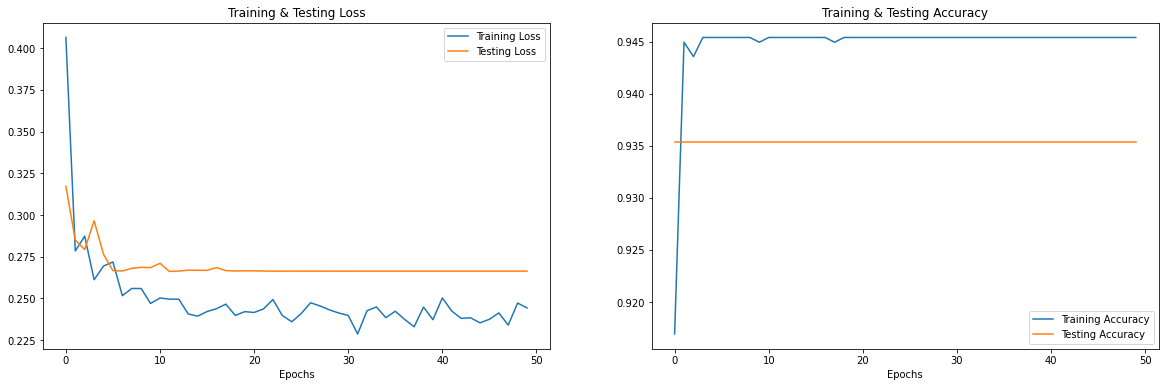

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [31]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

23/23 [==============================] - 0s 10ms/step


In [32]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,joy,joy
1,joy,joy
2,joy,joy
3,joy,joy
4,joy,joy
5,joy,joy
6,joy,joy
7,joy,joy
8,joy,joy
9,joy,surprise


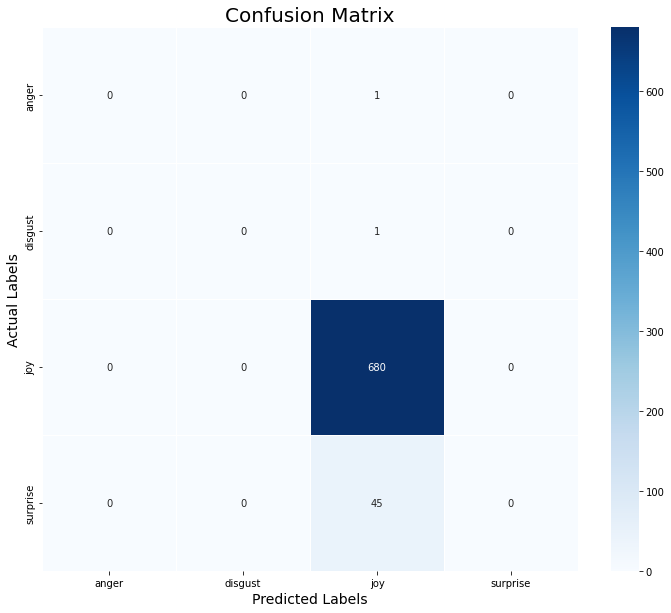

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         1
     disgust       0.00      0.00      0.00         1
         joy       0.94      1.00      0.97       680
    surprise       0.00      0.00      0.00        45

    accuracy                           0.94       727
   macro avg       0.23      0.25      0.24       727
weighted avg       0.87      0.94      0.90       727

